# Introduction - myFitbud Project

In this Notebook, I build a predictive model that estimates the number of calories burnt during physical activity using Multiple Regression. 

This analysis is valuable because it allows individuals and fitness platforms to estimate energy expenditure in real time, even when direct caloric measurement is unavailable. Understanding how different variables contribute to calorie burn — especially across genders — can improve fitness tracking, personalize workout recommendations, and enhance health analytics.

# Project Goals

- Build a **predictive model** to estimate `Calories Burnt` based on physiological and workout-related features such as `Workout Duration`, `Heart Rate`, `Body Temperature`, `Gender`, `Height`, `Weight`, and `Age`.
- Apply a range of **Unsupervised Learning techniques**, including data visualizations, Principal Component Analysis (PCA), and clustering, to explore patterns and structure in the data.
- Implement multiple **Supervised Learning techniques**, including Multiple Linear Regression (MLR), and interaction modeling, to build and evaluate predictive models.
- Adopt an **experimental and hypothesis-driven approach**: regularly pause to interpret results, form new hypotheses, and refine the analysis — enabling deeper understanding of both the data and the methods applied.
- Develop a workflow that is **reproducible and transferable**, so that the techniques and concepts used here can be applied to other datasets.

> Dataset Source: [Calories Burnt Dataset on Kaggle](https://www.kaggle.com/datasets/figolm10/calories-dataset)

The dataset was sourced from Kaggle and contains two CSV files:

- `exercise.csv`: Contains physiological and workout-related data.
  - **User_ID**: Unique identifier for each individual
  - **Gender**: Biological sex of the user (Male/Female)
  - **Age**: Age in years
  - **Height**: Height in centimeters
  - **Weight**: Weight in kilograms
  - **Duration**: Duration of physical activity (in minutes)
  - **Heart_Rate**: Average heart rate during exercise
  - **Body_Temp**: Average body temperature during exercise (likely in °F or °C)

- `calories.csv`: Contains the target variable — number of calories burnt per activity session.
  - **User_ID**: Matches the one in `exercise.csv`
  - **Calories**: Number of calories burned

The two datasets are merged on `User_ID` to form the full modeling dataset. The combined dataset has **15,000 rows** and **9 columns**


In [46]:
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import pandas as pd
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LinearRegression
from sklearn.cluster import KMeans
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.model_selection import train_test_split, KFold, cross_val_score
from sklearn.pipeline import make_pipeline
import statsmodels.api as sm

In [47]:
# I start by merging the two datasets
df1 = pd.read_csv("exercise.csv")
df2 = pd.read_csv("calories.csv")
df = pd.merge(df1, df2)
df.describe()

,User_ID,Age,Height,Weight,Duration,Heart_Rate,Body_Temp,Calories
count,1.500000e+04,15000.000000,15000.000000,15000.000000,15000.000000,15000.000000,15000.000000,15000.000000
mean,1.497736e+07,42.789800,174.465133,74.966867,15.530600,95.518533,40.025453,89.539533
std,2.872851e+06,16.980264,14.258114,15.035657,8.319203,9.583328,0.779230,62.456978
min,1.000116e+07,20.000000,123.000000,36.000000,1.000000,67.000000,37.100000,1.000000
25%,1.247419e+07,28.000000,164.000000,63.000000,8.000000,88.000000,39.600000,35.000000
50%,1.499728e+07,39.000000,175.000000,74.000000,16.000000,96.000000,40.200000,79.000000
75%,1.744928e+07,56.000000,185.000000,87.000000,23.000000,103.000000,40.600000,138.000000
max,1.999965e+07,79.000000,222.000000,132.000000,30.000000,128.000000,41.500000,314.000000


**Important Inference:** Just based of this description, it can be seen that heart rate and temperature increase when doing exercise

# Data Cleaning

In [48]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 15000 entries, 0 to 14999
Data columns (total 9 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   User_ID     15000 non-null  int64  
 1   Gender      15000 non-null  object 
 2   Age         15000 non-null  int64  
 3   Height      15000 non-null  float64
 4   Weight      15000 non-null  float64
 5   Duration    15000 non-null  float64
 6   Heart_Rate  15000 non-null  float64
 7   Body_Temp   15000 non-null  float64
 8   Calories    15000 non-null  float64
dtypes: float64(6), int64(2), object(1)
memory usage: 1.0+ MB


Since gender is a string, it needs to be converted to something quantitative \
Note that it is also a binary variable, so we can use binary label encoding \

In [49]:
# .str.strip() removes whitespace 
df["Gender"] = df["Gender"].str.strip()
# .map() function is used to replace values in a column - it takes a dictionary as argument.
df["Gender"] = df["Gender"].map({"male": 1, "female": 0})

In [50]:
df.head()

,User_ID,Gender,Age,Height,Weight,Duration,Heart_Rate,Body_Temp,Calories
0,14733363,1,68,190.0,94.0,29.0,105.0,40.8,231.0
1,14861698,0,20,166.0,60.0,14.0,94.0,40.3,66.0
2,11179863,1,69,179.0,79.0,5.0,88.0,38.7,26.0
3,16180408,0,34,179.0,71.0,13.0,100.0,40.5,71.0
4,17771927,0,27,154.0,58.0,10.0,81.0,39.8,35.0


# How well is the data distributed?

Visualizing the distribution of our variables gives an initial understanding of our data. Things to look out for: Is the data fairly normal? Are certain variables biased or skewed in one direction? 

In [51]:
# I start by setting a colour scheme for all the visualizations
custom_palette = ["#0D1B40", "#1E3A8A", "#5AA9E6", "#A1C9F1", "#CDE6F5"]
sns.set(style="whitegrid", palette=custom_palette, context="notebook")

## Distributions of Age, Height, Weight & Calories Burnt

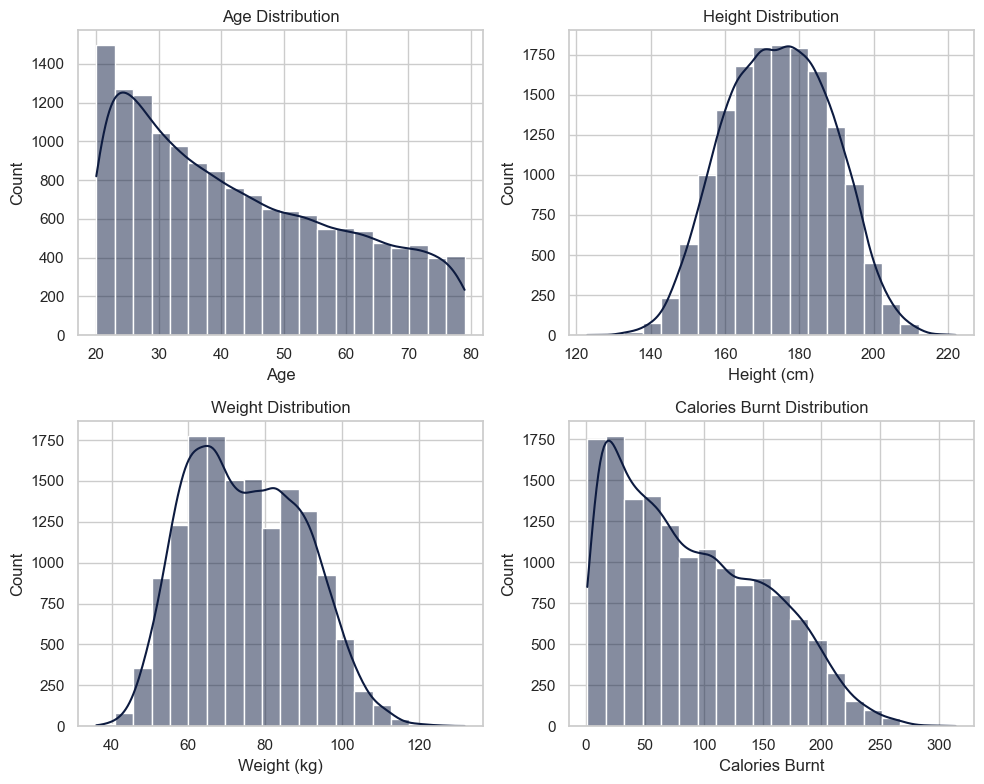

In [52]:
fig, axes = plt.subplots(2, 2, figsize=(10, 8))

# Age
sns.histplot(df["Age"], bins=20, kde=True, ax=axes[0, 0])
axes[0, 0].set_title("Age Distribution")
axes[0, 0].set_xlabel("Age")
axes[0, 0].set_ylabel("Count")
# Height 
sns.histplot(df["Height"], bins=20, kde=True, ax=axes[0, 1])
axes[0, 1].set_title("Height Distribution")
axes[0, 1].set_xlabel("Height (cm)")
axes[0, 1].set_ylabel("Count")
# Weight 
sns.histplot(df["Weight"], bins=20, kde=True, ax=axes[1, 0])
axes[1, 0].set_title("Weight Distribution")
axes[1, 0].set_xlabel("Weight (kg)")
axes[1, 0].set_ylabel("Count")
# Calories Burnt 
sns.histplot(df["Calories"], bins=20, kde=True, ax=axes[1, 1])
axes[1, 1].set_title("Calories Burnt Distribution")
axes[1, 1].set_xlabel("Calories Burnt")
axes[1, 1].set_ylabel("Count")

plt.tight_layout()
plt.show()

## Distributions of Gender, Workout Duration, Heart Rate & Body Temp

/var/folders/p7/4nzyv6d501sd69r7jl8gx1fw0000gn/T/ipykernel_53302/2169773925.py:8: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  axes[0, 0].set_xticklabels(["Female", "Male"])


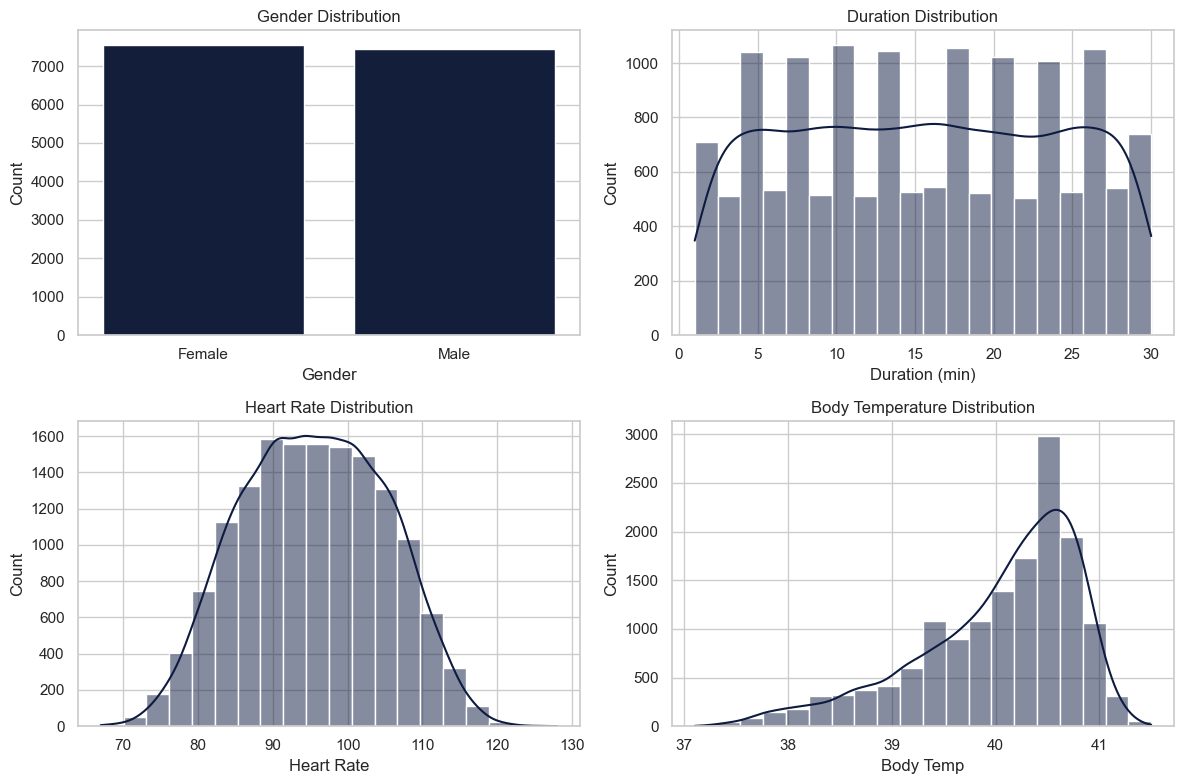

In [53]:
fig, axes = plt.subplots(2, 2, figsize=(12, 8))

# Gender Count Plot
sns.countplot(x="Gender", data=df, ax=axes[0, 0])
axes[0, 0].set_title("Gender Distribution")
axes[0, 0].set_xlabel("Gender")
axes[0, 0].set_ylabel("Count")
axes[0, 0].set_xticklabels(["Female", "Male"])
# Duration 
sns.histplot(df["Duration"], bins=20, kde=True, ax=axes[0, 1])
axes[0, 1].set_title("Duration Distribution")
axes[0, 1].set_xlabel("Duration (min)")
axes[0, 1].set_ylabel("Count")
# Heart Rate 
sns.histplot(df["Heart_Rate"], bins=20, kde=True, ax=axes[1, 0])
axes[1, 0].set_title("Heart Rate Distribution")
axes[1, 0].set_xlabel("Heart Rate")
axes[1, 0].set_ylabel("Count")
# Body Temperature 
sns.histplot(df["Body_Temp"], bins=20, kde=True, ax=axes[1, 1])
axes[1, 1].set_title("Body Temperature Distribution")
axes[1, 1].set_xlabel("Body Temp")
axes[1, 1].set_ylabel("Count")

plt.tight_layout()
plt.show()

From the visualizations above, we observe the following:

- **Gender Distribution**: The dataset is well-balanced between males and females, which is great as we will train an unbiased model that incorporates gender-based interactions.
- **Age Distribution**: Most individuals are in their 20s, with frequency gradually decreasing as age increases. This introduces a potential skew toward younger individuals, which could influence calorie predictions.
- **Height and Heart Rate**: Both are approximately **normally distributed**, suggesting that these features are well-behaved and centered around physiological averages. No major outliers are evident.
- **Weight**: A majority of individuals between 60–80 kg. There are heavier individuals present, but fewer in number.
- **Body Temperature:** This is **left-skewed**, with most values clustered between 40–41°C and a longer tail toward lower temperatures.
- **Duration**: The distribution appears relatively **uniform**, indicating that the dataset includes a wide range of workout lengths without strong bias toward any specific duration.
- **Calories Burnt**: This is **right-skewed**, with a large number of low-to-moderate calorie burns and fewer high-calorie sessions. This reflects the natural variation in workout intensities and durations.

# Principle Component Analysis (PCA)

In [54]:
X = df.drop(["User_ID", "Calories"], axis=1)
Y = df["Calories"]

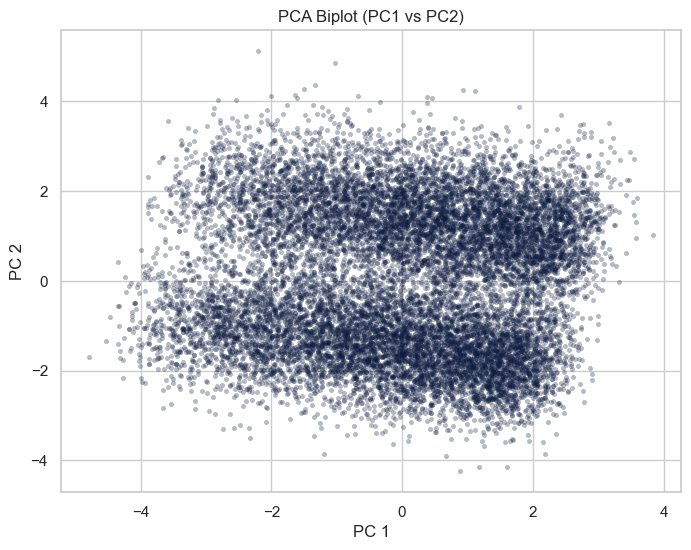

In [55]:
# It is crucial to standardize the dataset for conducting a PCA
scaler = StandardScaler() # Create an object of the StandardScaler class

# Fit calculates the mean and sd of each column,
# and transform standardizes the data
X_scaled = scaler.fit_transform(X)

# X_pca is the transformed matrix where
# each row is a data point
# each column is a principle component
pca = PCA() # Create an instance of the PCA model
X_pca = pca.fit_transform(X_scaled)

plt.figure(figsize=(8,6))
sns.scatterplot(x=X_pca[:,0], y=X_pca[:,1], 
                alpha=0.3,  # Adjust transparency to reduce clutter
                s=10,  # Set small marker size
                edgecolor=None)
plt.xlabel("PC 1")
plt.ylabel("PC 2")
plt.title("PCA Biplot (PC1 vs PC2)")
plt.show()

**What is the percentage variance explained by the PCs?**

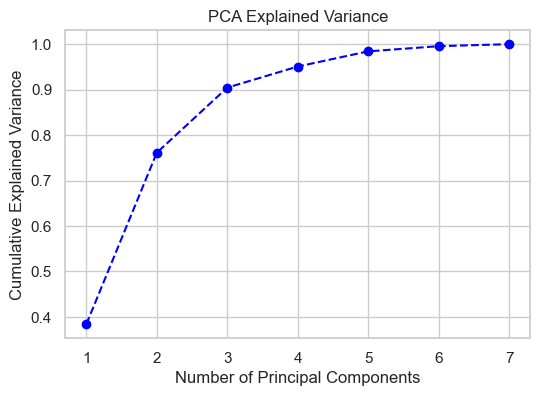

,Principal Component,Explained Variance Ratio,Cumulative Variance
0,PC1,38.40%,38.40%
1,PC2,37.71%,76.12%
2,PC3,14.32%,90.44%
3,PC4,4.64%,95.08%
4,PC5,3.34%,98.42%
5,PC6,1.14%,99.56%
6,PC7,0.44%,100.00%


In [56]:
# Returns a numpy array with each element represents a PC
var = pca.explained_variance_ratio_
#print(explained_variance)

cumulative_var = np.cumsum(var)

# Display the explained variance as a Scree Plot - this is a
# great visual to understand the % variance explained by the PCs
plt.figure(figsize=(6,4))
plt.plot(range(1, len(var)+1), 
         cumulative_var, 
         marker='o', linestyle='--', color='b')

plt.xlabel("Number of Principal Components")
plt.ylabel("Cumulative Explained Variance")
plt.title("PCA Explained Variance")
plt.grid(True)
plt.show()

# Display the explained variance for each PC as a table
var_table = pd.DataFrame({
    "Principal Component": [f"PC{i+1}" for i in range(len(var))],
    "Explained Variance Ratio": var,
    "Cumulative Variance": cumulative_var
})
var_table = var_table.style.format({
    "Explained Variance Ratio": "{:.2%}",
    "Cumulative Variance": "{:.2%}"
})

display(var_table)

We see that the first **two PCs** together explain **76%** of the variance.\
That's pretty good - 76% of the information can be visualised in just two dimensions!

Moving on, I will display the **loadings** of the PCs to see if they have any meaningful interpretations

In [57]:
feature_names = ["Gender", "Age", "Height", "Weight", "Duration", "Heart_Rate", "Body_Temp"]
pca_loadings = pd.DataFrame(
    pca.components_.T, # Transpose so rows are features
    columns=[f"PC{i+1}" for i in range(pca.n_components_)], # Name PCs
    index=feature_names # Set correct feature names
)

# Function that highlights the first two PCs in the table
def highlightPC(x):
    return ['background-color: #e6f2ff' 
            if x.name in ["PC1", "PC2"] 
            else '' for _ in x]

styled_pca = pca_loadings.style.apply(highlightPC, axis=0)
display(styled_pca)

,PC1,PC2,PC3,PC4,PC5,PC6,PC7
Gender,0.104445,0.530773,-0.061270,0.827390,-0.026444,0.002906,-0.135407
Age,0.019208,0.034461,0.996468,0.038987,0.001352,-0.000291,-0.063039
Height,0.106765,0.576134,-0.043462,-0.491092,0.013676,0.004830,-0.642962
Weight,0.112229,0.591652,0.035366,-0.267889,0.008280,-0.002134,0.751175
Duration,0.582025,-0.113707,-0.006297,-0.007835,-0.147425,0.791497,0.003978
Heart_Rate,0.553542,-0.103712,-0.009205,0.021443,0.778232,-0.276840,-0.002298
Body_Temp,0.565302,-0.106882,-0.005854,-0.021189,-0.609643,-0.544845,-0.002383


## Interpreting the first two PCs

It looks like PC1 is dominated by Heart Rate, Body Temp, and Workout Duration.\
And PC2 is dominated by Height, and Weight.\
\
It seems like the first two PCs have meaningful interpretations.\
PC1 -> **'Workout Intensity'** \
PC2 -> **'Body Size'** \
\
Let us graph the loadings of our features, and see how this **manifests visually.**

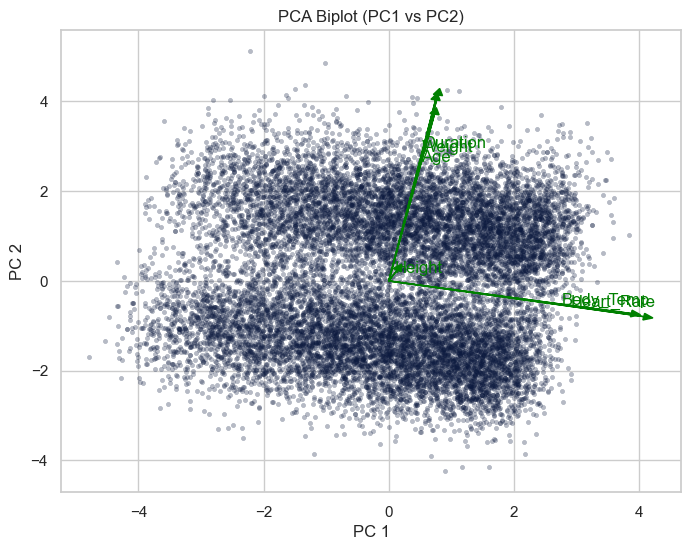

In [58]:
plt.figure(figsize=(8,6))
sns.scatterplot(x=X_pca[:,0], y=X_pca[:,1], 
                alpha=0.3, # Adjust the transparency to reduce clutter
                s=10, # Set small marker size
                edgecolor=None)

# Plot feature vectors (PCA loadings) as arrows
for i, feature in enumerate(["Age", "Height", "Weight", "Duration", "Heart_Rate", "Body_Temp"]):
    plt.arrow(0, 0, 
              pca.components_[0, i]*7,
              pca.components_[1, i]*7,  
              color='green', 
              alpha=1, 
              head_width=0.15, 
              head_length=0.15)
    plt.text(pca.components_[0, i]*5, 
             pca.components_[1, i]*5, 
             feature, 
             color='green', 
             fontsize=12)
plt.xlabel("PC 1")
plt.ylabel("PC 2")
plt.title("PCA Biplot (PC1 vs PC2)")
plt.show()

Summary of PCA and some observations:
1. PC1 and PC2 cover most of the variance at ~ 76%
2. The first two PCs likely mean workout intensity and body size respectively
3. There is clustering taking place in the direction of PC2

**Hypothesis:** The two clusters formed in the direction of PC2 represent Male and Female groups.
- The dataset contains only one binary variable (Gender).\
   Since PCA does not know about categorical variables, yet two clear clusters are forming, it is likely due to the only binary feature in the dataset (Gender).
- PC2 is associated with 'Body Size'.\
   If PC2 strongly correlates with Height and Weight, then it aligns with known biological differences between males and females.\
   In most populations, males are generally taller and heavier than females, which would explain why PC2 separates into two distinct clusters.\
  PC1 (Workout Intensity) does not group the data.\
\
I use a K-means clustering algorithm to see if we find the same clusters.

# K-means clustering

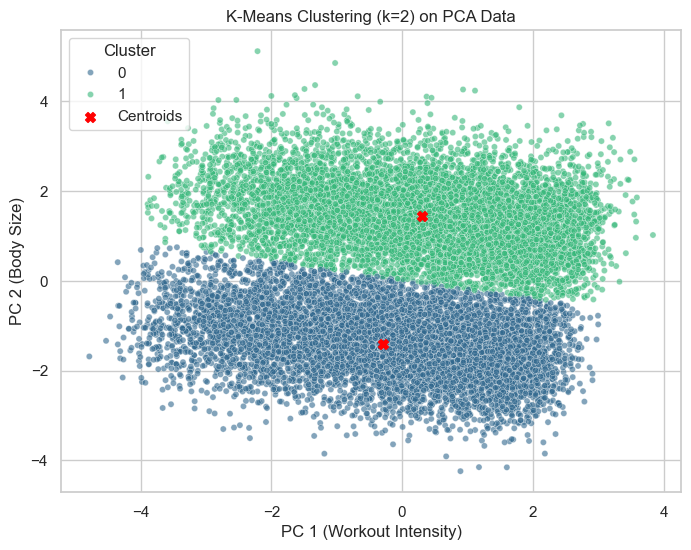

In [59]:
k = 2 # We know how many clusters we are trying to find
kmeans = KMeans(n_clusters=k, random_state=42, n_init=10) # Algorithm will run 10 times with different centroid seeds
df["Cluster"] = kmeans.fit_predict(X_pca[:, :2]) # Create new column 'Cluster' in our data frame

plt.figure(figsize=(8,6))
sns.scatterplot(x=X_pca[:, 0], 
                y=X_pca[:, 1], 
                hue=df["Cluster"], 
                palette="viridis", 
                alpha=0.6, 
                s=20)

# Returns the coordinates of the centroids
# Since we are in 2D, this is a 2x2 matrix
centers = kmeans.cluster_centers_
#print(centers)
plt.scatter(centers[:, 0], centers[:, 1], c="red", marker="X", s=50, label="Centroids")

plt.xlabel("PC 1 (Workout Intensity)")
plt.ylabel("PC 2 (Body Size)")
plt.title(f"K-Means Clustering (k={k}) on PCA Data")
plt.legend(title="Cluster")
plt.show()

Great! K-means has found the same clusters.\
Now let's test our hypothesis - we already know the gender distribution of our data.

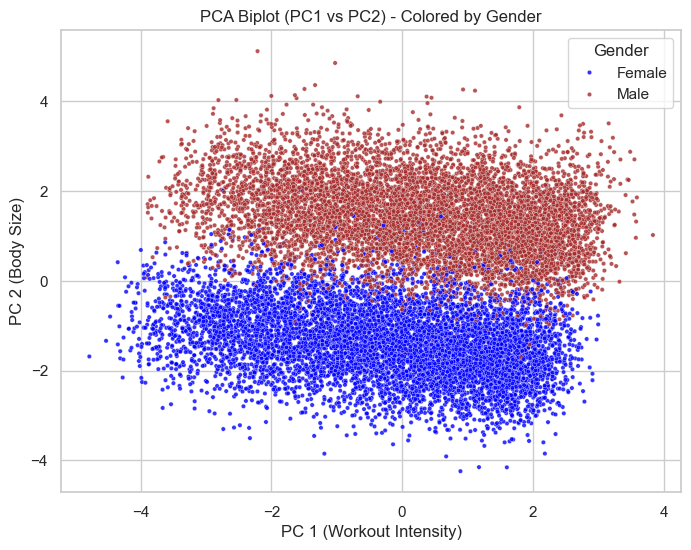

In [60]:
plt.figure(figsize=(8,6))
ax = sns.scatterplot(x=X_pca[:, 0], 
                     y=X_pca[:, 1], 
                     hue=df["Gender"], 
                     palette={0: "blue", 1: "brown"},
                     alpha=0.8, 
                     s=10)

# I need to manually update the legend labels to show 'Male' and 'Female' instead of 0 and 1
handles, labels = ax.get_legend_handles_labels()
ax.legend(handles, ["Female", "Male"], title="Gender")

plt.xlabel("PC 1 (Workout Intensity)")
plt.ylabel("PC 2 (Body Size)")
plt.title("PCA Biplot (PC1 vs PC2) - Colored by Gender")
plt.show()

Barring some outliers, we see that the K-Means clustering algorithm correctly identified the two groups.\
Our hypothesis that the clusters represented male and female groups has been validated.

# Model Building

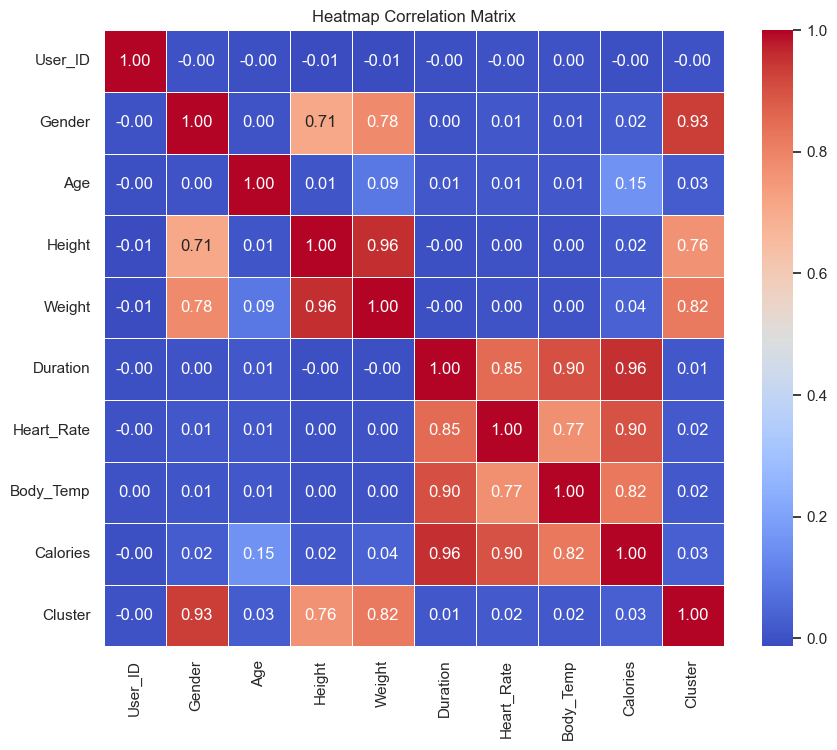

In [61]:
corr_matrix = df.corr()

plt.figure(figsize=(10, 8))
sns.heatmap(corr_matrix, annot=True, cmap="coolwarm", fmt=".2f", linewidths=0.5)
plt.title("Heatmap Correlation Matrix")
plt.show()

We can see that there is a 93% correlation between 'Gender' and 'Cluster', also verifying our previous hypothesis.

# Model 1: Multiple Linear Regression (MLR)

To start with - I build a basic **multiple linear regression.** 

$
\text{Calories} = \beta_0 
+ \beta_1 \cdot \text{Age} 
+ \beta_2 \cdot \text{Height} 
+ \beta_3 \cdot \text{Weight} 
+ \beta_4 \cdot \text{Duration} 
+ \beta_5 \cdot \text{Heart\_Rate} 
+ \beta_6 \cdot \text{Body\_Temp} 
+ \beta_7 \cdot \text{Gender} 
+ \epsilon
$

In [62]:
features = ["Age", "Height", "Weight", "Duration", "Heart_Rate", "Body_Temp", "Gender"]
X = df[features]
y = df["Calories"]

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.3, random_state=42
)

# Standardize the features - this is always good practice before fitting the model
# We only fit on the training data to prevent data leakage - we are pretending the model hasn't
# "seen" the test data
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# The model I have chosen is linear regression. I create an instance of it and
# fit the training data to the model
model = LinearRegression()
model.fit(X_train_scaled, y_train)

y_pred = model.predict(X_test_scaled)
mse = mean_squared_error(y_test, y_pred) 
rmse = np.sqrt(mse) # root mean squared error / out-of-sample prediction error!
r2 = r2_score(y_test, y_pred)

print("Test RMSE:", round(rmse, 2))
print("Test R² Score:", round(r2, 4))

# Create a data frame to view the coefficients
coefficients = pd.DataFrame({
    "Feature": features,
    "Coefficient": model.coef_
})
coefficients

Test RMSE: 11.53
Test R² Score: 0.9663


,Feature,Coefficient
0,Age,8.460986
1,Height,-2.532620
2,Weight,4.461420
3,Duration,55.191797
4,Heart_Rate,18.966810
5,Body_Temp,-13.240901
6,Gender,-0.676440


In [63]:
pipeline = make_pipeline(StandardScaler(), LinearRegression())
cv = KFold(n_splits=5, shuffle=True, random_state=42)

# Get cross-validated RMSE scores 
# Scikit-learn returns negative values for loss-type scores
# So we negate the scores to get the actual RMSE
rmse_scores = -cross_val_score(pipeline, X, y, cv=cv, scoring="neg_root_mean_squared_error")

cv_rmse_mean = rmse_scores.mean()
cv_rmse_std = rmse_scores.std()
cv_relative_std = (cv_rmse_std / cv_rmse_mean) * 100 # Relative std for context
print("Cross-Validated RMSE (mean):", round(cv_rmse_mean, 2))
print("Cross-Validated RMSE (std):", round(cv_rmse_std, 2))
print("Relative CV RMSE std (%):", round(cv_relative_std, 2))

Cross-Validated RMSE (mean): 11.32
Cross-Validated RMSE (std): 0.16
Relative CV RMSE std (%): 1.38


In [64]:
print("Min:", df["Calories"].min())
print("Max:", df["Calories"].max())
print("Range:", df["Calories"].max() - df["Calories"].min())

Min: 1.0
Max: 314.0
Range: 313.0


### Analysis of Model 1

**Key Results:**

- **Relative RMSE** (%) = $\frac{RMSE}{Range} = \frac{11.53}{313} \approx 3.7\%$. Nice!
- **Model Generalizability:** Low RMSE standard deviation (= 1.38) shows predictions are not overfit to specific subsets.
- **Model interpretability:** The coefficients are interpretable and provide a basic understanding of how they affect calories burnt.

This model is great for making predictions!

####  Question: Do we need to conduct Regularized Regression?
In other words, is our variance too high?

We can answer this by analyzing the model's **bias-variance balance** using the following diagnostics:

1. **Adjusted R²:** Adjusted R² accounts for model complexity by penalizing the inclusion of unnecessary predictors.  
2. **Standard Deviation of Cross-Validated RMSE**

In [66]:
# Adjusted R² from statsmodels

X_with_const = sm.add_constant(X) # statsmodels requires us to manually add a constant term (unlike scikit-learn)
ols_model = sm.OLS(y, X_with_const).fit() # fit the simple linear regression model
adj_r2 = ols_model.rsquared_adj # use the in-built sm method for Adj R2

print("Relative CV RMSE std (%):", round(cv_relative_std, 2))
print("Adjusted R²:", round(adj_r2, 4))

Relative CV RMSE std (%): 1.38
Adjusted R²: 0.9672


Our Adjusted R^2 score is **0.9672** which is very close to the test R^2 score (**0.9663**).\
Our CV RMSE standard deviation was **0.15**, which is only **1.38%** of the mean RMSE — indicating very stable performance across folds.\
\
We do not need to conduct regularized regression.

# Model 2: MLR with Gender Interactions

The basic MLR model is great for making predictions! But that's just half the story... I want to understand the dataset as much as possible.

We have a categorical variable that we worked a lot with in the unsupervised learning section of this notebook. Let's see how we can **use supervised learning** to **discover trends** in the dataset. 

**Interaction terms:** Gender is known to influence physiological characteristics and exercise responses. As a result, the relationship between predictors and calories burnt may differ between males and females.\
For example:
- A 30-minute run might burn more calories for a male than a female, even if heart rate is the same.
- Body weight may have a stronger effect on calorie burn in one gender than the other.

By including interaction terms, we allow the model to adapt its behavior for each gender, rather than assuming the same slope (effect size) applies universally.\
\
While we could have interacted Gender with every feature, this has its own cons. We don't want too many variables in our model as this increases model complexity. We have chosen which are the appropriate features to interact with gender:
- **Gender × Duration →** To allow time spent exercising to have a different calorie impact across genders
- **Gender × Heart Rate →** Heart rate patterns and their calorie relationship vary by sex
- **Gender × Weight →** Body weight can affect calorie burn differently depending on body composition (which differs by gender)

Here is the MLR model with gender interactions:

$
\text{Calories} = \beta_0 
+ \beta_1 \cdot \text{Age} 
+ \beta_2 \cdot \text{Height} 
+ \beta_3 \cdot \text{Weight} 
+ \beta_4 \cdot \text{Duration} 
+ \beta_5 \cdot \text{Heart\_Rate} 
+ \beta_6 \cdot \text{Body\_Temp} 
+ \beta_7 \cdot \text{Gender}
$
$
+ \beta_8 \cdot (\text{Gender} \cdot \text{Duration}) 
+ \beta_9 \cdot (\text{Gender} \cdot \text{Heart\_Rate}) 
+ \beta_{10} \cdot (\text{Gender} \cdot \text{Weight}) 
+ \epsilon
$

In [67]:
# I start by creating the interaction terms and adding them to the data frame
df["Gender_Duration"] = df["Gender"] * df["Duration"]
df["Gender_HeartRate"] = df["Gender"] * df["Heart_Rate"]
df["Gender_Weight"] = df["Gender"] * df["Weight"]

features_interact = [
    "Age", "Height", "Weight", "Duration", "Heart_Rate", "Body_Temp", "Gender",
    "Gender_Duration", "Gender_HeartRate", "Gender_Weight"
]

# From here on, any variable with a _i infront of it refers to the interaction model
# This follows the exact same procedure as the previous model 

X_i = df[features_interact]
y_i = df["Calories"]

X_train_i, X_test_i, y_train_i, y_test_i = train_test_split(
    X_i, y_i, test_size=0.3, random_state=42
)

scaler_i = StandardScaler()
X_train_i_scaled = scaler_i.fit_transform(X_train_i)
X_test_i_scaled = scaler_i.transform(X_test_i)

model_interact = LinearRegression()
model_interact.fit(X_train_i_scaled, y_train_i)

y_pred_i = model_interact.predict(X_test_i_scaled)
mse_i = mean_squared_error(y_test_i, y_pred_i) 
rmse_i = np.sqrt(mse_i) 
r2_i = r2_score(y_test_i, y_pred_i)

print("Test RMSE:", round(rmse_i, 2))
print("Test R² Score:", round(r2_i, 4))

Test RMSE: 10.61
Test R² Score: 0.9715


In [68]:
pipeline = make_pipeline(StandardScaler(), LinearRegression())
cv = KFold(n_splits=5, shuffle=True, random_state=42)

rmse_scores_interact = -cross_val_score(pipeline, X_i, y_i, cv=cv, scoring="neg_root_mean_squared_error")

cv_rmse_mean_i = rmse_scores_interact.mean()
cv_rmse_std_i = rmse_scores_interact.std()
cv_relative_std_i = (cv_rmse_std_i / cv_rmse_mean_i) * 100 # Relative std for context
print("Cross-Validated RMSE (mean):", round(cv_rmse_mean_i, 2))
print("Cross-Validated RMSE (std):", round(cv_rmse_std_i, 2))
print("Relative CV RMSE std (%):", round(cv_relative_std_i, 2))

Cross-Validated RMSE (mean): 10.43
Cross-Validated RMSE (std): 0.15
Relative CV RMSE std (%): 1.48


### Analysis of Model 2

We see that, even slightly so, this model performed even better than Model 1.

**Key Results:**

- **Relative RMSE** (%) = $\frac{RMSE}{Range} = \frac{10.16}{313} \approx 3.4\%$. Slightly nicer!
- **Model Generalizability:** Low RMSE std - no overfitting to specific subsets - model is generalizable.
- **Model remains interpretable:** Despite interactions, coefficients are understandable and allow insights into how different variables behave across genders.
- **The inclusion of gender interaction terms was valuable**:
  - They capture gender-specific effects in how workout metrics translate into calorie burn.
  - This added flexibility improves the model without overly increasing complexity.

This model is also great for making predictions, but there are some really cool insights we can derive by analysing the results of running this model.

### Coefficient Interpretation: MLR with Gender Interactions

The table below breaks down the key coefficients from our Multiple Linear Regression model, focusing on the role of **gender interaction terms**.

Since females map to 0 and males map to 1, we treat females as the baseline group, meaning that the main effect coefficients (like `Duration`, `Heart_Rate`, `Weight`) represent their direct impact on calorie burn for females. The interaction terms (like `Gender_Duration`) show how those relationships change for males.

In [72]:
coefficients_interact = pd.DataFrame({
    "Feature": features_interact,
    "Coefficient": model_interact.coef_
})

# Function to highlight the interaction terms
def highlight_interactions(row):
    return ['background-color: #e6f2ff' if 'Gender_' in str(row['Feature']) else '' for _ in row]

# Style and display
styled_coef_table = coefficients_interact.style.apply(highlight_interactions, axis=1)
display(styled_coef_table)

,Feature,Coefficient
0,Age,8.739095
1,Height,0.362654
2,Weight,-4.353757
3,Duration,54.816038
4,Heart_Rate,15.963647
5,Body_Temp,-13.032455
6,Gender,-54.867736
7,Gender_Duration,0.559094
8,Gender_HeartRate,30.561505
9,Gender_Weight,28.728300


### Some observations:

- Calories burnt increase by 55 per min of exercise for females. The effect is about the same for males.
- Calories burnt increase by 16 per unit heart rate for females. For males, heart rate effect = 46.73 (16 + 30.77) — a huge jump.
- Weight reduces calorie estimate in females. For males, weight effect = 24.7 (−4.3 + 29).
- Males burn ~55 fewer calories at baseline (Duration = 0), offset by interactions.

So, we see that
- **Duration** is the strongest driver of calories for both genders, but **males burn slightly more per minute** than females.
- **Heart Rate** shows a dramatically higher effect in males: **nearly triple the increase in calories per BPM**.
- **Weight** shows a negative relationship for females (possibly due to fat vs. muscle composition), but **reverses for males**, indicating a higher burn per kg — likely due to more natural lean mass.

This is a key point that I found interesting:
- The **Gender** coefficient itself is negative, suggesting males burn fewer calories at baseline. But this is offset by the stronger effects of the interaction terms.

# Machine Learning = Data Science $\cap$ Software Engineering !
The next part of this project provides a simple UI feature, that allows the user to input predictor values and see how many calories are burnt. The model used is the MLR with gender interactions, as that performed better of the two.

This is where a lot of the experimenting, data intuition, and understanding of trends takes place. We can isolate certain variables and see the effect size of others. 

Above the UI feature, I have displayed the coeffecient table of the relevant model as a reference while experimenting. This provides an intuition for what the coefficients mean.

In [45]:
import ipywidgets as widgets
from IPython.display import display, clear_output

gender = widgets.Dropdown(options=["Female", "Male"], description="Gender:")
age = widgets.IntSlider(value=25, min=10, max=80, step=1, description="Age:")
height = widgets.IntSlider(value=165, min=100, max=220, step=1, description="Height (cm):")
weight = widgets.IntSlider(value=70, min=30, max=150, step=1, description="Weight (kg):")
duration = widgets.IntSlider(value=30, min=1, max=180, step=1, description="Duration (min):")
heart_rate = widgets.IntSlider(value=100, min=60, max=200, step=1, description="Heart Rate:")
body_temp = widgets.FloatSlider(value=37.0, min=35.0, max=42.0, step=0.1, description="Body Temp (°C):")

predict_button = widgets.Button(description=" Predict Calories Burnt ")
output = widgets.Output()

# This function makes a prediction of calories burnt using the input values given by the user (through widgets)
# and using the model we defined earlier. It outputs the predicted calories in a formatted way in the output
# space defined above
def predict_calories(b):
    with output:
        clear_output() # if something already is written in the output space, clear it.
        gender_val = 1 if gender.value == "Male" else 0
        # Gather inputs and calculate interaction terms
        input_values = [
            age.value,
            height.value,
            weight.value,
            duration.value,
            heart_rate.value,
            body_temp.value,
            gender_val,
            gender_val * duration.value,
            gender_val * heart_rate.value,
            gender_val * weight.value
        ]

        # Standardize input using previously fitted scaler
        input_df = pd.DataFrame([input_values], columns=X_i.columns)
        input_scaled = scaler.transform(input_df)

        # Predict using trained MLR model
        prediction = model_interact.predict(input_scaled)[0]
        predicted_cals = round(prediction, 1)

        # Prints result in the designated output space (the one we cleared earlier)
        print(f" Estimated Calories Burnt: {predicted_cals} ")

# Here we connect our button to our function
# predict_button is a widgets.Button() object
# .on_click() is a method that takes the function as argument
predict_button.on_click(predict_calories)

# Display UI
ui = widgets.GridBox([
    gender, age, height, weight, duration, heart_rate, body_temp,
    predict_button, output
])
display(coefficients_interact)
display(ui)

,Feature,Coefficient
0,Age,8.739095
1,Height,0.362654
2,Weight,-4.353757
3,Duration,54.816038
4,Heart_Rate,15.963647
5,Body_Temp,-13.032455
6,Gender,-54.867736
7,Gender_Duration,0.559094
8,Gender_HeartRate,30.561505
9,Gender_Weight,28.728300


GridBox(children=(Dropdown(description='Gender:', options=('Female', 'Male'), value='Female'), IntSlider(value…